In [2]:
!pip install -U pip setuptools wheel
!pip install jupyter pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost lightgbm
!pip install kagglehub

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")

In [4]:
#To download datset from Kaggle:
import kagglehub
from pathlib import Path
import pandas as pd

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset") 
print("Path to dataset files:", path)

Path to dataset files: /Users/leilatawfik/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


In [5]:
p= Path(path)
df = pd.read_csv(p / "healthcare-dataset-stroke-data.csv")
print(df.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


           count  percent
stroke                   
No stroke   4861    95.13
Stroke       249     4.87
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
        gender          age  hypertension  heart_dise

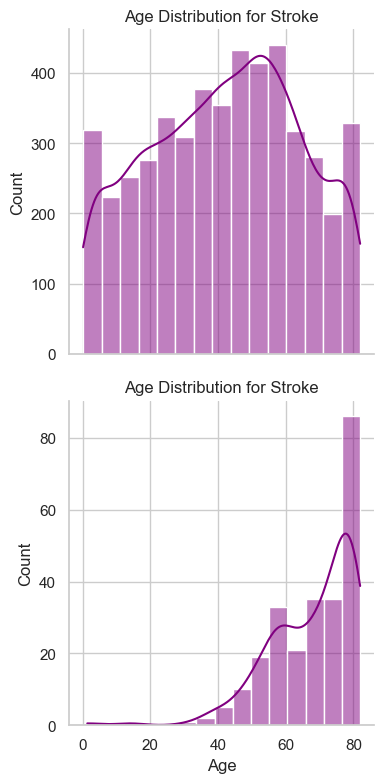

In [6]:




#PREPROCESSING STEPS
#Create new DataFrame without missing BMI values
df ["bmi"] = df["bmi"].fillna(df["bmi"].median()) #Imputation of BMI values

#Stroke vs No stroke
dist = df["stroke"].value_counts().sort_index()
pct  = (df["stroke"].value_counts(normalize=True).sort_index() * 100).round(2)
summary = pd.DataFrame({"count": dist, "percent": pct}).rename(index={0:"No stroke", 1:"Stroke"})
print(summary)

#Data types and null value info:
df.info()

#Removing dupliactes
df.drop_duplicates(inplace = True)

#Drop ID column
df.drop(columns=['id'], inplace=True, errors='ignore')


#Description of stats
print (df.describe (include = "all"))

#How many missing values exist in each column
print (df.isnull().sum())


#Change categorical data into numerical values
if "gender" in df.columns:
    df = df[df["gender"].isin(["Male", "Female"])].copy()
df.drop(columns=["gender_num"], inplace=True, errors="ignore")

if "gender" in df.columns and not any(c.startswith("gender_") for c in df.columns):
    df = pd.get_dummies(df, columns=["gender"], drop_first=False)

for c in ["gender_Male", "gender_Female"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)







if "ever_married" in df.columns and "is_ever_married" not in df.columns:
  df['is_ever_married'] = df['ever_married'].map({'No':0,'Yes':1})
df.drop(columns=["ever_married"], inplace=True, errors="ignore")
if "Residence_type" in df.columns and "is_urban" not in df.columns:
  df['is_urban'] = df['Residence_type'].map({'Rural':0,'Urban':1})
df.drop(columns=["Residence_type"], inplace=True, errors="ignore")
if "work_type" in df.columns and not any(c.startswith("work_type_") for c in df.columns):
    df = pd.get_dummies(df, columns=["work_type"], drop_first=True)
if "smoking_status" in df.columns and not any(c.startswith("smoking_status_") for c in df.columns):
    df = pd.get_dummies(df, columns=["smoking_status"], drop_first=True)



#To make sure NaN doesn't show up in our binary values:
int_like_cols = ["hypertension", "heart_disease", "stroke",
                 "gender_num", "is_ever_married", "is_urban"]
for col in int_like_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

#Print overall values
print ("Final columns:", list (df.columns))

#Print missing values
print (df.isnull().sum())

#Checking for class imbalances
if "stroke" in df.columns:
    vc = df["stroke"].value_counts().sort_index() #---> any class imbalances here will be printed as a percentage
    pct = (vc / len(df) * 100). round(2)
    print(pd.DataFrame({"count": vc, "percent": pct}))
else:
    print("column 'stroke' not found.")

#Checking for extremes in the dataset
for col in ["avg_glucose_level", "bmi"]:
    if col in df.columns:
        d = df[col].describe()
        print (f"{col}: min={d['min']: .2f}, 25%={d['25%']:.2f}, median={d['50%']:.2f}, 75%={d['75%']:.2f}, max={d['max']:.2f}")
    else:
        print(f"{col}: not in dataframe")


#Overview of age and gender demographics
if "age" in df.columns:
    d = df["age"].describe()
    print(f"Age --> mean={d['mean']:.2f}, std={d['std']:.2f}, min={d['min']:.2f}, max={d['max']:.2f}")

if "gender" in df.columns: #---> gender here is changed to a % distribution
    print("\nGender distribution (%):")
    print((df["gender"].value_counts(normalize=True) * 100).round(2))

#Top Correlations
num = df.select_dtypes(include="number").copy()
corr = num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
pairs = corr.where(mask).stack().rename("corr")
print("\nTop 5 strongest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=False).index).head(5).round(3))

print("\nBottom 5 weakest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=True).index).head(5).round(3))


# Create a FacetGrid for multiple histograms
g = sns.FacetGrid(df, col="stroke", col_wrap=1, height=4, sharex=True, sharey=False)
g.map(sns.histplot, "age", kde=True, bins=15, color="purple")

# Add titles
g.set_axis_labels("Age", "Count")
g.set_titles("Age Distribution for Stroke")

# Show plot
plt.tight_layout()
plt.show()

In [7]:
#i just changed this to another cell so i can run it wihtout running the model
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score

In [8]:

#Statistical tests to find best evaluation metrics 

#Fairness measures:

def get_gender_series(X: pd.DataFrame) -> np.ndarray:   #For fairness, reconstructing one hot encoding so evaluate gender and ensure no original labels were lost
    if "gender" in X.columns:
        return X["gender"].astype(str).values
    if "gender_Female" in X.columns:
        return np.where(X["gender_Female"].values > 0.5, "Female", "Male")
    return np.array(["Unknown"]* len(X))

def statistical_parity_difference(y_pred: np.ndarray, gender: np.ndarray) -> float: #Statistical parity difference for fairness check to find if model flags one group mroe than another
    m_f = (gender == "Female")
    m_m = (gender == "Male")
    if not m_f.any() or not m_m.any():
        return np.nan
    return y_pred[m_f].mean() - y_pred[m_m].mean()


#Feature engineering targets for the model
data = df.copy()

if "gender" in data.columns: #if any gender columns still exist, convert to male or female
    data = data[data["gender"].isin(["Male", "Female"])]


#Model target
data["stroke"] = pd.to_numeric(data["stroke"], errors="coerce").fillna(0).astype(int)
y = data["stroke"].values
X = data.drop(columns=["stroke"])

#Data classification as numeric, binary or categorical 
numeric_features = [c for c in ["age", "avg_glucose_level", "bmi"] if c in X.columns]
binary_features  = [c for c in ["hypertension", "heart_disease"] if c in X.columns]
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

#Leak based processing to ensure preprocessing statistics is only done on the training data and can be used for validation tests
numeric_tfm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tfm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tfm, numeric_features),
        ("cat", categorical_tfm, categorical_features),
        ("bin", "passthrough", binary_features)
    ],
    remainder="drop"
)

#Defining our model
model = LogisticRegression(
    class_weight="balanced",  # important with ~5% positives
    solver="liblinear",
    max_iter=200,
    random_state=42
)

clf = Pipeline(steps=[("prep", preprocessor), ("model", model)])

#10 fold K test and SPD
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1s, accs, pr_aucs, roc_aucs, spds = [], [], [], [], []

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y[tr], y[te]

    # Save raw gender for fairness --> one hot encode gender was used in pipeline, here membership is needed per row
    gender_te = get_gender_series(X_te)

    # Fit on train, predict on test
    clf.fit(X_tr, y_tr)
    y_scores = clf.predict_proba(X_te)[:, 1]
    y_pred = (y_scores >= 0.5).astype(int)  # simple default threshold

    # Accuracy metrics
    accs.append(accuracy_score(y_te, y_pred))
    f1s.append(f1_score(y_te, y_pred, zero_division=0))
    pr_aucs.append(average_precision_score(y_te, y_scores))  # PR-AUC
    roc_aucs.append(roc_auc_score(y_te, y_scores))           # optional

    # Fairness statistical parity difference 
    spds.append(statistical_parity_difference(y_pred, gender_te))



#Print Output
def mean_std(a): 
    return f"{np.mean(a):.3f} ± {np.std(a):.3f}"

print("\n 10-fold results (mean ± std)")
print(f"Accuracy : {mean_std(accs)}")
print(f"F1-score : {mean_std(f1s)}")
print(f"PR-AUC   : {mean_std(pr_aucs)}")
print(f"ROC-AUC  : {mean_std(roc_aucs)}")
print(f"SPD (Female - Male) : {mean_std(spds)}")

#^^ turn that into table data for presentation




 10-fold results (mean ± std)
Accuracy : 0.735 ± 0.014
F1-score : 0.224 ± 0.025
PR-AUC   : 0.215 ± 0.047
ROC-AUC  : 0.842 ± 0.023
SPD (Female - Male) : -0.015 ± 0.055


In [9]:
y = data["stroke"]           
X = data.drop(columns=["stroke"])  

#80/20 test/train split
#stratifying the data for equal distribution of classes between test and training data
#random state for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

#k-fold stratification for X_train
#10 folds, and the training and validation sets are shuffled
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#empty list for the results of each fold 
fold_results = []
fold = 1

#training and validation loops, with model fitting and evaluation
for train_index, test_index in skf.split(X_train, y_train):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

    rf = RandomForestClassifier(n_estimators=300, max_depth=None, class_weight='balanced', random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)

    accs = accuracy_score(y_val, y_pred)
    f1s = f1_score(y_val, y_pred, zero_division=0)
    pr_aucs = average_precision_score(y_val, y_pred)  # PR-AUC
    roc_aucs = roc_auc_score(y_val, y_pred)          # optional

    print(f"\nFold {fold}: Accuracy={accs:.2f}, F1={f1s:.2f}, PR_AUC={pr_aucs:.2f}, ROC_AUC={roc_aucs:.2f}")

    fold_results.append({
        "fold": fold,
        "accuracy": accs,
        "f1": f1s,
        "pr_auc": pr_aucs, 
        "roc_auc": roc_aucs
    })
    
    fold += 1




Fold 1: Accuracy=0.92, F1=0.00, PR_AUC=0.08, ROC_AUC=0.50

Fold 2: Accuracy=0.96, F1=0.00, PR_AUC=0.04, ROC_AUC=0.50

Fold 3: Accuracy=0.93, F1=0.00, PR_AUC=0.07, ROC_AUC=0.50

Fold 4: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 5: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 6: Accuracy=0.94, F1=0.00, PR_AUC=0.06, ROC_AUC=0.50

Fold 7: Accuracy=0.93, F1=0.00, PR_AUC=0.06, ROC_AUC=0.49

Fold 8: Accuracy=0.93, F1=0.00, PR_AUC=0.06, ROC_AUC=0.50

Fold 9: Accuracy=0.93, F1=0.00, PR_AUC=0.07, ROC_AUC=0.50

Fold 10: Accuracy=0.93, F1=0.07, PR_AUC=0.07, ROC_AUC=0.52


In [11]:
from xgboost import XGBClassifier

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/leilatawfik/Desktop/FALL 2025/Reproducible_and_ResponsibleAI/.venv/lib/python3.14/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\n  Referenced from: <B111F8D5-6AC6-3245-A6B5-94693F6992AB> /Users/leilatawfik/Desktop/FALL 2025/Reproducible_and_ResponsibleAI/.venv/lib/python3.14/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib' (no such file)"]


In [ ]:
#trying a different model here